# Lecture 4

* Sampling
* Automatic gradient
* Parallel computing on GPUs
* Cython

In [2]:
import numpy as np
import numpy.random as rnd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Sampling

Draw random samples from a uniform distribution.

In [3]:
rnd.uniform?

In [4]:
U = rnd.uniform(-1,1, size = 500)
print(U.shape)
print("Mean: {:0.03f} var: {:0.02f}".format(U.mean(), U.var()))

(500,)
Mean: 0.006 var: 0.31


Draw random samples from a normal (Gaussian) distribution.

In [5]:
rnd.normal?

In [6]:
G = rnd.normal(loc = 1, scale = 10, size = [1000,2])
print(G.shape)
print("Mean: [{:0.03f},{:0.03f}]".format(*np.mean(G,0)))

(1000, 2)
Mean: [0.950,0.889]


[22 11 15 20  8 12 16 17 16 19 20 14 25 15 18 19 16 18 12 25 14 20 16 24
  8 18 20 19  8 15]
[-0.99190391 -0.92563863 -0.85937334 -0.79310806 -0.72684277 -0.66057749
 -0.5943122  -0.52804692 -0.46178164 -0.39551635 -0.32925107 -0.26298578
 -0.1967205  -0.13045521 -0.06418993  0.00207535  0.06834064  0.13460592
  0.20087121  0.26713649  0.33340178  0.39966706  0.46593234  0.53219763
  0.59846291  0.6647282   0.73099348  0.79725877  0.86352405  0.92978934
  0.99605462]


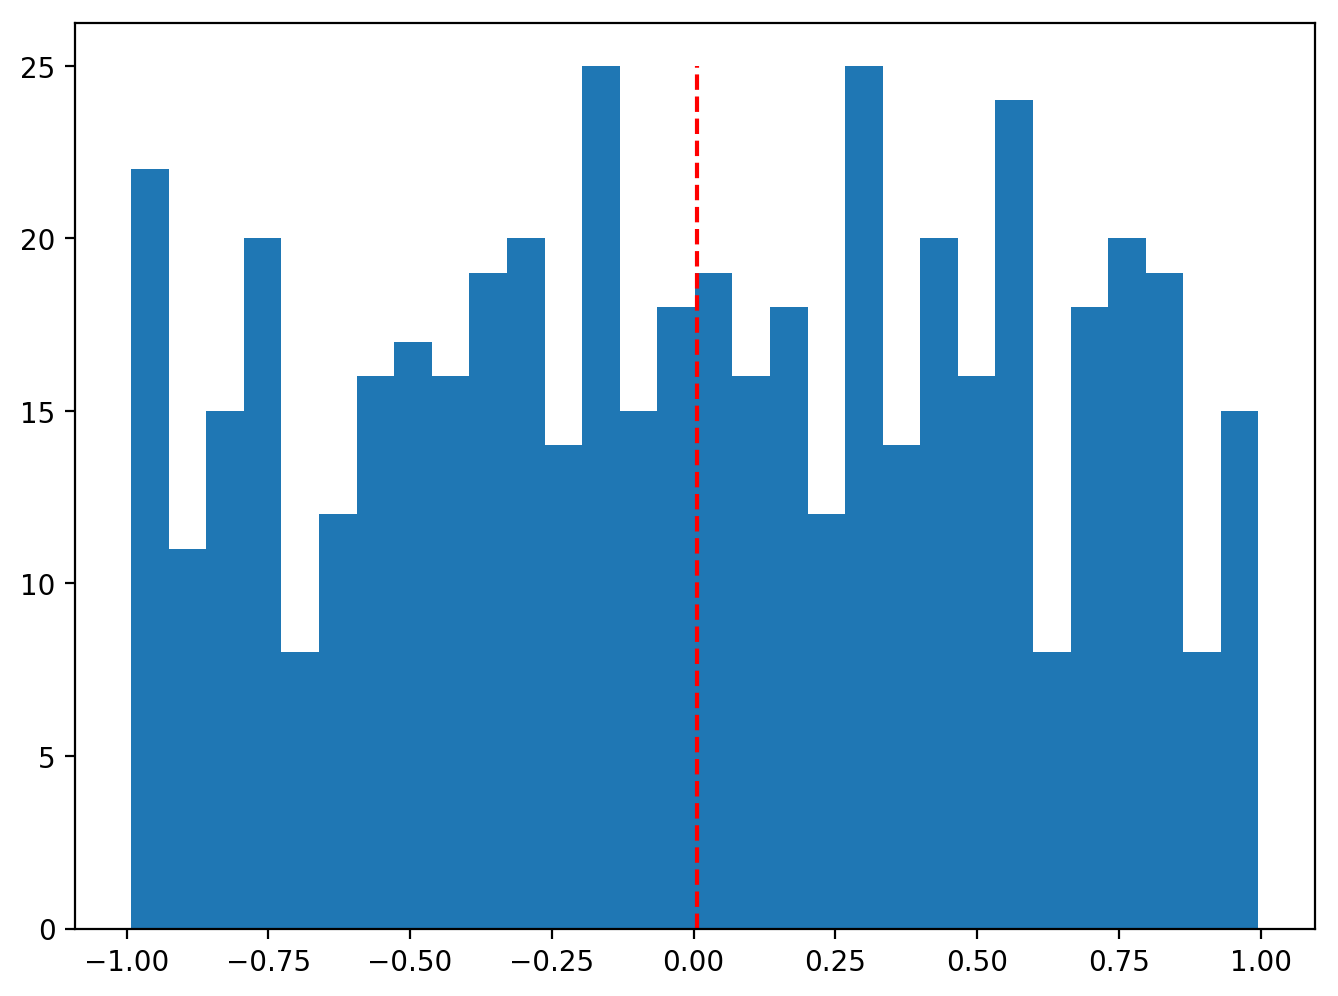

In [7]:
num_bins = 30

nums,ranges = np.histogram(U, bins = num_bins)

print(nums)
print(ranges)

plt.figure(figsize=(8,6), dpi=200)
_ = plt.hist(U, bins=num_bins)

_ = plt.plot([U.mean()]*2,[0, np.max(nums)], '--', color ='r') # plot dashed mean line

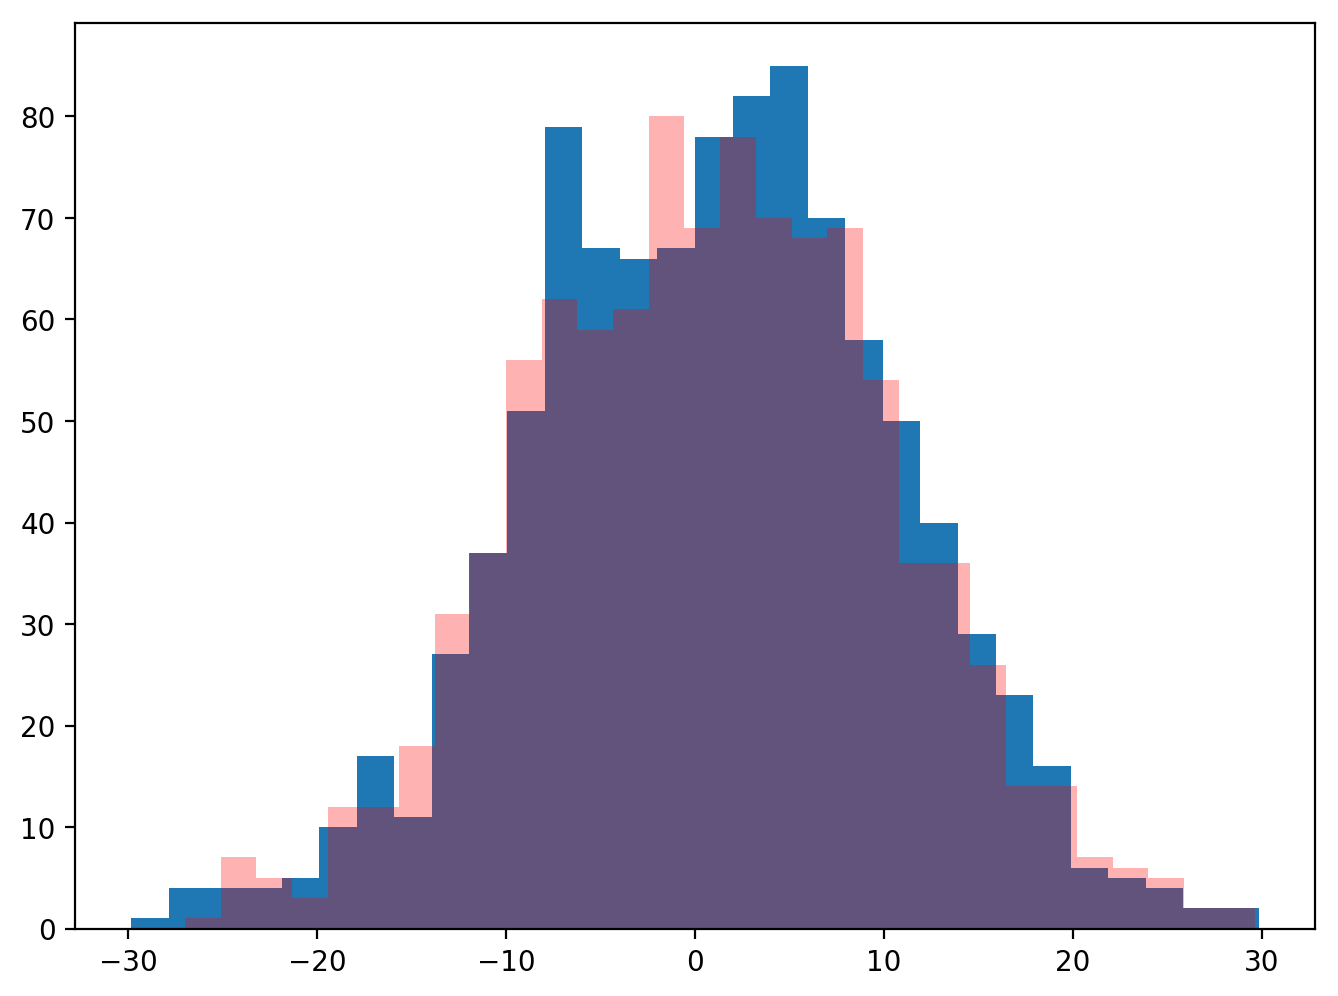

In [8]:
plt.figure(figsize=(8,6), dpi=200)
_ = plt.hist(G[:,0], bins=30)
_ = plt.hist(G[:,1], bins=30, alpha=0.3, color = 'r')

Let's draw some random samples from a multinomial distribution. We'll use our fruits from the first lecture.

![](fruits.png)

In [9]:
fruits = np.array([
    'watermelon',
    'apple',
    'grape',
    'grapefruit',
    'lemon',
    'banana',
    'cherry'
])

In [10]:
n = 5 # number of samples
p = [1/len(fruits)]*len(fruits)

repeat = np.tile(fruits, (n,1)) # repeat multiple (5) times
print(repeat)

mlt = rnd.multinomial(1, p, size=(5)) # draw multinomial samples 5 times with an equal probability
print(mlt)

samples =repeat[mlt.astype(bool)] # show drown samples
print(samples)

[['watermelon' 'apple' 'grape' 'grapefruit' 'lemon' 'banana' 'cherry']
 ['watermelon' 'apple' 'grape' 'grapefruit' 'lemon' 'banana' 'cherry']
 ['watermelon' 'apple' 'grape' 'grapefruit' 'lemon' 'banana' 'cherry']
 ['watermelon' 'apple' 'grape' 'grapefruit' 'lemon' 'banana' 'cherry']
 ['watermelon' 'apple' 'grape' 'grapefruit' 'lemon' 'banana' 'cherry']]
[[0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0]]
['lemon' 'banana' 'banana' 'grape' 'banana']


In [11]:
p = [0.05, 0.70, 0.05, 0.05, 0.05, 0.05, 0.05] # adjust probailities 

mlt = rnd.multinomial(1, p, size=(5)) # draw multinomial samples 5 times with given probabilities
print(mlt)

samples =repeat[mlt.astype(bool)] # show drown samples
print(samples)

[[0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]]
['apple' 'apple' 'apple' 'apple' 'apple']


### Another way to make discrete choices

![](sampling.png)

In [12]:
p = [0.05, 0.70, 0.05, 0.05, 0.05, 0.05, 0.05]

# Cumulate them
l = np.cumsum([0] + p[:-1]) # lower-bounds
h = np.cumsum(p)            # upper-bounds

print(l)
print(h)

# Draw a number between 0 and 1
u = np.random.uniform(0, 1)

# Find which basket it belongs to
s = np.logical_and(u > l, u < h)
print(s)

# retrieve the label
fruits[np.argmax(s)]

[0.   0.05 0.75 0.8  0.85 0.9  0.95]
[0.05 0.75 0.8  0.85 0.9  0.95 1.  ]
[False  True False False False False False]


'apple'

## Markov Chain

![](markov.png)

A Markov chain transits between a set of states, where the transition between pairs of states is associated with a fixed probability. The set of probabilities can be stored in a transition matrix.

In [13]:
# Transition matrix
T = np.array([
    [0.9,0.1,0.0], # transiting from state 1 to state 1,2,3
    [0.0,0.9,0.1], # transiting from state 2 to state 1,2,3
    [1.0,0.0,0.0], # transiting from state 3 to state 1,2,3
])

In [14]:
# Add empty state to transition matrix
pad_shape = ((0, 0), (1, 0))  # ((before_1, after_1), (before_2, after_2))
P = np.pad(T, pad_shape, mode='constant')
print(P)

[[0.  0.9 0.1 0. ]
 [0.  0.  0.9 0.1]
 [0.  1.  0.  0. ]]


In [15]:
def mcstep(X, P):
    Xp = np.dot(X, P)
    Xc = np.cumsum(Xp, axis=1)
    L,H = Xc[:, :-1], Xc[:, 1:]
    R = np.random.uniform(0, 1, (len(Xp), 1))
    states = np.logical_and((R > L), (R < H))
    #print(states.astype('int32'))
    return states.astype('int32')

In [17]:
A = np.tile([1.0,0,0], (5,1)) 
# or
A = np.outer(np.ones([5]),[1.0,0,0]) # (5,1) x (1,3) -> (5,3)

num_steps = 10
for i in range(num_steps):
    A = mcstep(A, P)
    
A.mean(axis=0)

array([0.6, 0.4, 0. ])

## Autograd
(https://github.com/HIPS/autograd)

In [21]:
import autograd.numpy as ag_np
from autograd import grad
x = ag_np.ones(1)
y = lambda x: 3 * x**2 + 2
print(grad(y)(x))

float64
[6.]


In [22]:
x1 = ag_np.ones(1)
x2 = ag_np.ones(1)

y = lambda x1,x2 : 3*x1**3 + 4*2**x2

print(grad(y,0)(x1,x2))
print(grad(y,1)(x1,x2)) # 4*2**x2*ln(x2)

[9.]
[5.54517744]


In [26]:
y = lambda x: x**2
step_size = 0.2
xs = np.array([-5.0])
while abs(grad(y)(xs[-1])) > 1e-2:
    curr_val = xs[-1]
    next_val = curr_val - step_size*grad(y)(curr_val)
    xs = np.append(xs, next_val)

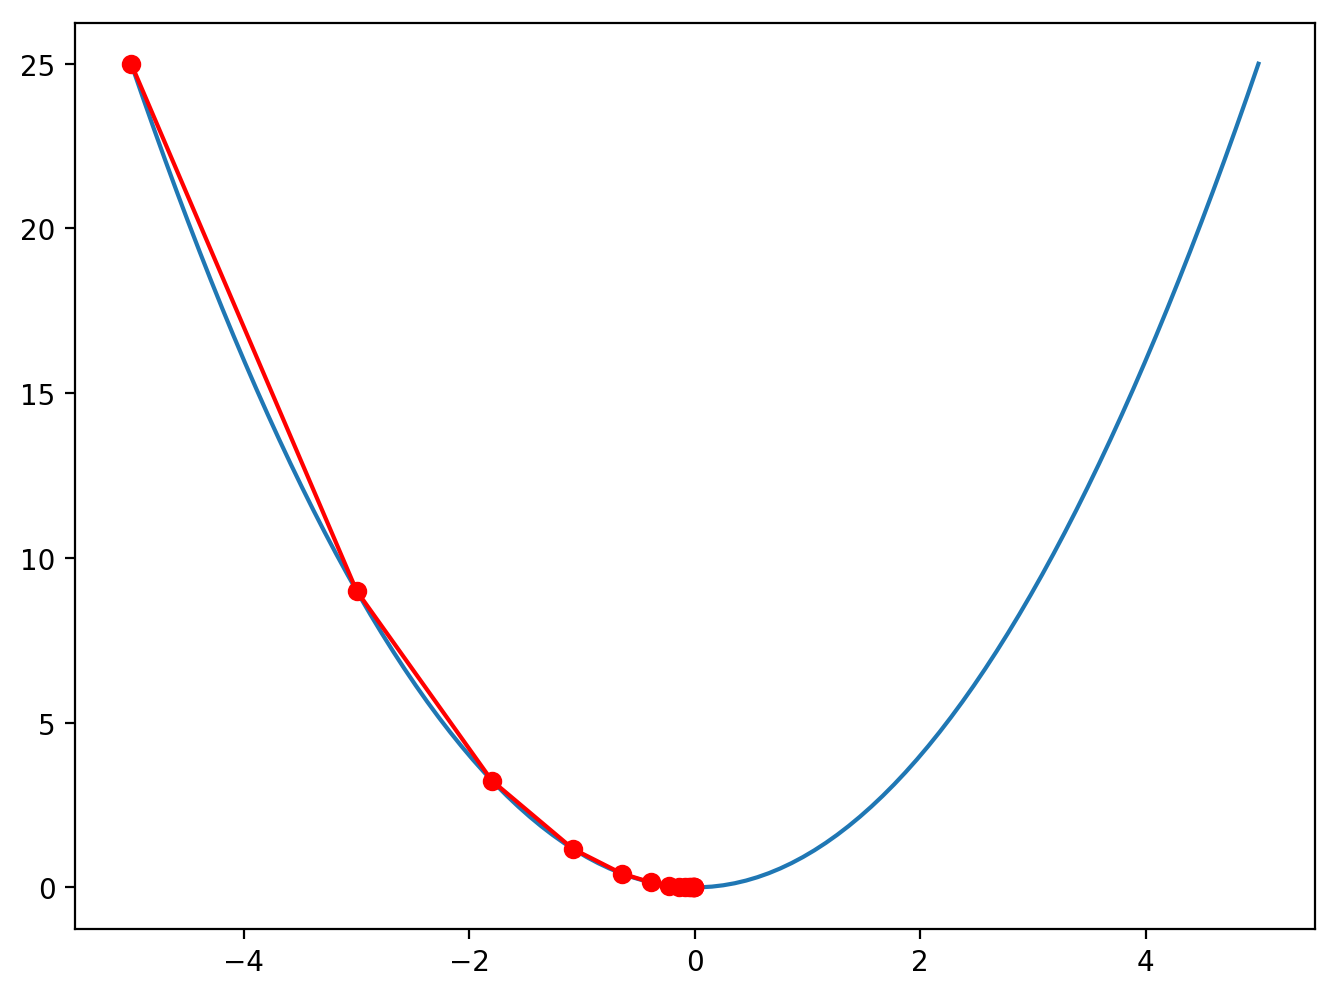

In [27]:
x = np.linspace(-5, 5, 100)
plt.figure(figsize=(8,6), dpi=200)
_ = plt.plot(x,y(x))
_ = plt.plot(xs, y(xs), "-o", c="r")

## GPUs
(https://github.com/cupy/cupy)

In [36]:
import numpy as np
from time import time
n = 1000
X = np.random.normal(size = (n,n))
Y = np.random.normal(size = (n,n))
%timeit X.dot(Y)

5.64 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
import cupy as cp
X = cp.array(X)
Y = cp.array(Y)
%timeit X.dot(Y)

571 µs ± 346 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Cython

* Create new file *hello.pyx*. See the example file (hello.pyx) in the same Folder. The file contains a custom implementation of the matrix product with loops

#### Cython hello.pyx file

<code>
cimport cython
import numpy as np
cimport openmp
from cython.parallel cimport prange

@cython.boundscheck(False)
@cython.wraparound(False)

cpdef dot(float[:,:] X, float[:,:] Y): 
    cdef:
        int n,i,j,k
        float[:,:] Z
    n = X.shape[0]
    Z = np.zeros((n,n), dtype = 'float')
    n = len(X)
    for i in prange(n, nogil = True):
        for j in range(n):
            for k in range(n):
                Z[i,j] += X[i, k] * Y[k, j]
    return Z
</code>

* Create *setup.py* with compiler commands in order to build a new python package. See example file in the same folder

#### setup.py file

<code>
from distutils.core import setup
from Cython.Build import cythonize
from distutils.extension import Extension
from Cython.Distutils import build_ext
 
setup(
  name = "hello",
  cmdclass = {"build_ext": build_ext},
  ext_modules =
  [
    Extension("hello",
              ["hello.pyx"],
              extra_compile_args = ["-O0", "-fopenmp"],
              extra_link_args=['-fopenmp']
              )
  ]
)
</code>

Compile the *hello.pyx* file with the following command from terminal. 
 * *python setup.py build_ext --inplace*
 
After your module is compiled you can import it into your notebook as usual

You can profile your cython code in order to know, either your computations are made efficiently. For the reason you may create an HTML file highlighting the line with the bad performance.

Create file profiling snapshot by calling the following command in your terminal
* *cython -a hello.pyx*

Then open a new generated *hello.html* file in a browser. The lines colored yellow still need some python interactions and therefore slow, so you can still find a way to optimize them. But for now it's enought to have no yellow lines within the loops.

![](profiling.png)

#### Import your brand new module as usual 

In [50]:
import hello

In [ ]:
Test the performance. It

In [51]:
from time import time
X = np.array(X.tolist()).astype('float32')
Y = np.array(X.tolist()).astype('float32')
%timeit hello.dot(X,Y)

783 ms ± 43.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As you already know normal python loops will take much more time to finish all the computations...

In [47]:
st = time()
Z = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        for k in range(n):
            Z[i,j] += X[i, k] * Y[k, j]
print(time() - st)
print(np.sum(Z))

995.5045590400696
6907.071765647259
